In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import pandas as pd
import os

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Endoscope Detection/Yolov11/gastroscopy_meta_256.csv")

In [ ]:
df.head()

,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,256.0,256.0,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,95.478723,45.744681,163.031915,93.617021,ulcer
1,1_1_00011.png,256.0,256.0,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,143.617021,112.234043,177.659574,135.372340,ulcer
2,1_1_00014.png,256.0,256.0,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,65.159574,70.212766,134.840426,153.191489,ulcer
3,1_1_00017.png,256.0,256.0,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,110.574468,62.765957,172.010638,94.148936,ulcer
4,1_1_00018.png,256.0,256.0,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,145.148936,47.872340,206.851064,134.308511,ulcer


In [ ]:
from sklearn.model_selection import StratifiedKFold
df['label'] = df['image_id'].apply(lambda x: int(x.split('_')[1]))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in skf.split(df, df['label']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/Endoscope Detection/Yolov11/val.csv')
image_folder = r'/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/val'
label_folder = r'/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/val'

os.makedirs(label_folder, exist_ok=True)

for img_id in label_df['image_id']:
    img_file_path = os.path.join(image_folder, img_id)

    if os.path.exists(img_file_path):
        group = df[df['image_id'] == img_id]

        label_file_path = os.path.join(label_folder, f'{img_id.replace(".png", ".txt")}')

        with open(label_file_path, 'w') as label_file:
            for _, row in group.iterrows():
                obj_class = row['lesion_label']

                x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
                img_width, img_height = row['width'], row['height']

                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                label_file.write(f'{obj_class} {x_center} {y_center} {width} {height}\n')

In [ ]:
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/zidane.jpg'

100% 5.35M/5.35M [00:00<00:00, 60.3MB/s]
Ultralytics 8.3.67 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 49.2k/49.2k [00:00<00:00, 3.58MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 178.2ms
Speed: 24.1ms preprocess, 178.2ms inference, 40.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [10]:
import albumentations as A
from ultralytics.data.augment import Albumentations
from ultralytics.utils import LOGGER, colorstr


def new_init__(self, p=1.00):
        self.p = p
        self.transform = None
        prefix = colorstr("albumentations: ")

        try:
            import albumentations as A

            spatial_transforms = {
                "Affine",
                "BBoxSafeRandomCrop",
                "CenterCrop",
                "CoarseDropout",
                "Crop",
                "CropAndPad",
                "CropNonEmptyMaskIfExists",
                "D4",
                "ElasticTransform",
                "Flip",
                "GridDistortion",
                "GridDropout",
                "HorizontalFlip",
                "Lambda",
                "LongestMaxSize",
                "MaskDropout",
                "MixUp",
                "Morphological",
                "NoOp",
                "OpticalDistortion",
                "PadIfNeeded",
                "Perspective",
                "PiecewiseAffine",
                "PixelDropout",
                "RandomCrop",
                "RandomCropFromBorders",
                "RandomGridShuffle",
                "RandomResizedCrop",
                "RandomRotate90",
                "RandomScale",
                "RandomSizedBBoxSafeCrop",
                "RandomSizedCrop",
                "Resize",
                "Rotate",
                "SafeRotate",
                "ShiftScaleRotate",
                "SmallestMaxSize",
                "Transpose",
                "VerticalFlip",
                "XYMasking",
            }  # from https://albumentations.ai/docs/getting_started/transforms_and_targets/#spatial-level-transforms


            params = {
                 "num_masks_x": (1,2),
                 'num_masks_y': (1,2),
                 'mask_x_length': (10,20),
                 'mask_y_length': (10,20),
                 'fill_value': 0,
                   }

            T = [
                A.CLAHE(clip_limit=(2.0, 2.0), tile_grid_size=(8, 8), p=1.0),
                A.RandomBrightnessContrast(p=0.3)
            ]

            # Compose transforms
            self.contains_spatial = any(transform.__class__.__name__ in spatial_transforms for transform in T)
            self.transform = (
                A.Compose(T, bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
                if self.contains_spatial
                else A.Compose(T)
            )
            LOGGER.info(prefix + ", ".join(f"{x}".replace("always_apply=False, ", "") for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        except Exception as e:
            LOGGER.info(f"{prefix}{e}")

Albumentations.__init__ = new_init__

In [11]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

results = model.train(data="/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/data.yaml",
                      project="/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3",
                      name="exp3",
                      epochs=50,
                      imgsz=256,
                      hsv_h=0.0, #색조 삭제
                      hsv_s=0.25,
                      hsv_v=0.25,
                      degrees=0.25,
                      translate=0.25,
                      scale=0.0,
                      shear=0.0,
                      perspective=0.0,
                      flipud=0.5,
                      fliplr=0.5,
                      mosaic=0.3, #모자이크
                      mixup=0.3, # 이미지 혼합
                      auto_augment="none",
                      erasing=0.0,
                      copy_paste=0.0
                      )


Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3, name=exp33, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/train.cache... 1280 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/train/1_1_00024.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/train/1_1_00027.png: 1 duplicate labels removed
albumentations: CLAHE(p=1.0, clip_limit=(2.0, 2.0), tile_grid_size=(8, 8)), RandomBrightnessContrast(p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True)



val: Scanning /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/val.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.526G      1.593      3.026      1.596         37        256: 100%|██████████| 80/80 [06:05<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        320        450      0.257      0.123      0.176     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.52G      1.725      2.469      1.636         39        256: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        320        450      0.145       0.23      0.119      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.499G      1.704      2.322      1.633         38        256: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

                   all        320        450      0.379      0.293      0.223     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.52G      1.652      2.258      1.609         34        256: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        320        450      0.384      0.411      0.351      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.499G      1.625      2.182      1.593         32        256: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

                   all        320        450      0.456      0.396      0.359      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.499G      1.616      2.099      1.571         48        256: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        320        450      0.289      0.427      0.282      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.52G      1.622      2.075      1.569         34        256: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

                   all        320        450      0.501      0.377      0.389      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      0.52G      1.565      2.019      1.531         35        256: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

                   all        320        450      0.458       0.45      0.415      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      0.52G      1.527      1.967      1.535         41        256: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

                   all        320        450      0.376      0.394      0.317      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.52G       1.52      1.938      1.513         48        256: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

                   all        320        450      0.479      0.423      0.429      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.52G      1.492      1.879      1.487         40        256: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

                   all        320        450      0.573      0.461       0.45      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.497G      1.488      1.853       1.47         42        256: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        320        450      0.525      0.492      0.481      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.518G      1.452       1.82      1.464         25        256: 100%|██████████| 80/80 [00:25<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        320        450      0.458      0.493      0.435       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.499G      1.434      1.777      1.456         36        256: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

                   all        320        450      0.529      0.479      0.482      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.518G      1.448      1.779      1.452         38        256: 100%|██████████| 80/80 [00:24<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        320        450      0.546      0.558      0.511      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.499G      1.443      1.809       1.46         32        256: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

                   all        320        450      0.601      0.509      0.537      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.497G      1.432      1.737      1.458         34        256: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

                   all        320        450      0.632      0.537      0.542      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.518G      1.391      1.733      1.436         32        256: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        320        450      0.605       0.51      0.529      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.499G      1.409      1.736      1.431         25        256: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        320        450      0.648       0.46      0.533      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.518G      1.347       1.66      1.391         52        256: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        320        450       0.62      0.536      0.546      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.497G      1.363      1.673      1.409         32        256: 100%|██████████| 80/80 [00:25<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        320        450      0.627       0.53      0.563      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.497G       1.36      1.684      1.422         52        256: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

                   all        320        450      0.618      0.559      0.565      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.497G      1.345      1.664      1.409         37        256: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        320        450      0.692      0.544      0.605      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.497G      1.352      1.632       1.39         30        256: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        320        450      0.522      0.536      0.513      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.497G      1.336      1.617      1.398         41        256: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        320        450      0.648      0.577      0.595      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.497G      1.334      1.622      1.404         31        256: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        320        450      0.591      0.571      0.557      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.499G      1.335      1.606      1.379         33        256: 100%|██████████| 80/80 [00:24<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        320        450      0.633      0.558      0.584      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.518G       1.32      1.574      1.393         35        256: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        320        450      0.676      0.545      0.593      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.497G      1.281      1.561      1.371         40        256: 100%|██████████| 80/80 [00:25<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        320        450      0.614      0.574      0.561      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.518G      1.286      1.558      1.368         37        256: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        320        450      0.659      0.577      0.579      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.497G      1.283      1.531      1.369         39        256: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        320        450      0.759      0.532      0.602      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.497G      1.262      1.527      1.364         25        256: 100%|██████████| 80/80 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        320        450      0.608      0.597       0.58      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.518G      1.298      1.521      1.363         34        256: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

                   all        320        450      0.684      0.505      0.578      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.497G      1.263      1.506      1.355         35        256: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        320        450      0.719      0.582      0.622      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.497G      1.267      1.521       1.37         31        256: 100%|██████████| 80/80 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        320        450      0.694      0.578      0.605      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.497G      1.264      1.494      1.351         39        256: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        320        450       0.71      0.543      0.613      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.497G       1.25      1.482      1.348         29        256: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

                   all        320        450      0.635      0.572      0.603      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.497G      1.238      1.473      1.334         40        256: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        320        450       0.74      0.581       0.64      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.497G      1.224      1.434      1.337         34        256: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

                   all        320        450      0.746      0.575      0.634      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.497G      1.187      1.386      1.314         34        256: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        320        450      0.774      0.539      0.642      0.362


Closing dataloader mosaic
albumentations: CLAHE(p=1.0, clip_limit=(2.0, 2.0), tile_grid_size=(8, 8)), RandomBrightnessContrast(p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True)

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.518G      1.086      1.206      1.226         18        256: 100%|██████████| 80/80 [00:24<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        320        450      0.776      0.531      0.641      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.497G      1.056      1.145       1.21         26        256: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        320        450      0.716      0.553      0.634      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.497G      1.074      1.109       1.21         23        256: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        320        450      0.681      0.571      0.619      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.518G      1.055      1.091      1.203         19        256: 100%|██████████| 80/80 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        320        450      0.699      0.598      0.649      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.497G      1.047      1.078      1.193         19        256: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        320        450      0.693      0.581      0.631      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.497G      1.032      1.074      1.188         19        256: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

                   all        320        450      0.752      0.582      0.658      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.518G      1.004      1.036      1.175         24        256: 100%|██████████| 80/80 [00:22<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        320        450      0.715      0.576      0.644      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.497G      1.031      1.025      1.193         24        256: 100%|██████████| 80/80 [00:22<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

                   all        320        450      0.746      0.571      0.638      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.497G      1.004      1.008      1.169         18        256: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        320        450      0.762      0.579      0.652      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.518G      1.001      1.019      1.173         26        256: 100%|██████████| 80/80 [00:22<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        320        450       0.76      0.565      0.643       0.38



50 epochs completed in 0.516 hours.
Optimizer stripped from /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/weights/last.pt, 5.4MB
Optimizer stripped from /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/weights/best.pt, 5.4MB

Validating /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


                   all        320        450      0.748      0.585      0.658      0.387
                 ulcer         80        108      0.697      0.454      0.522      0.278
                 polyp         80        148      0.877      0.673      0.774       0.46
                cancer        160        194      0.671      0.629      0.679      0.424
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33


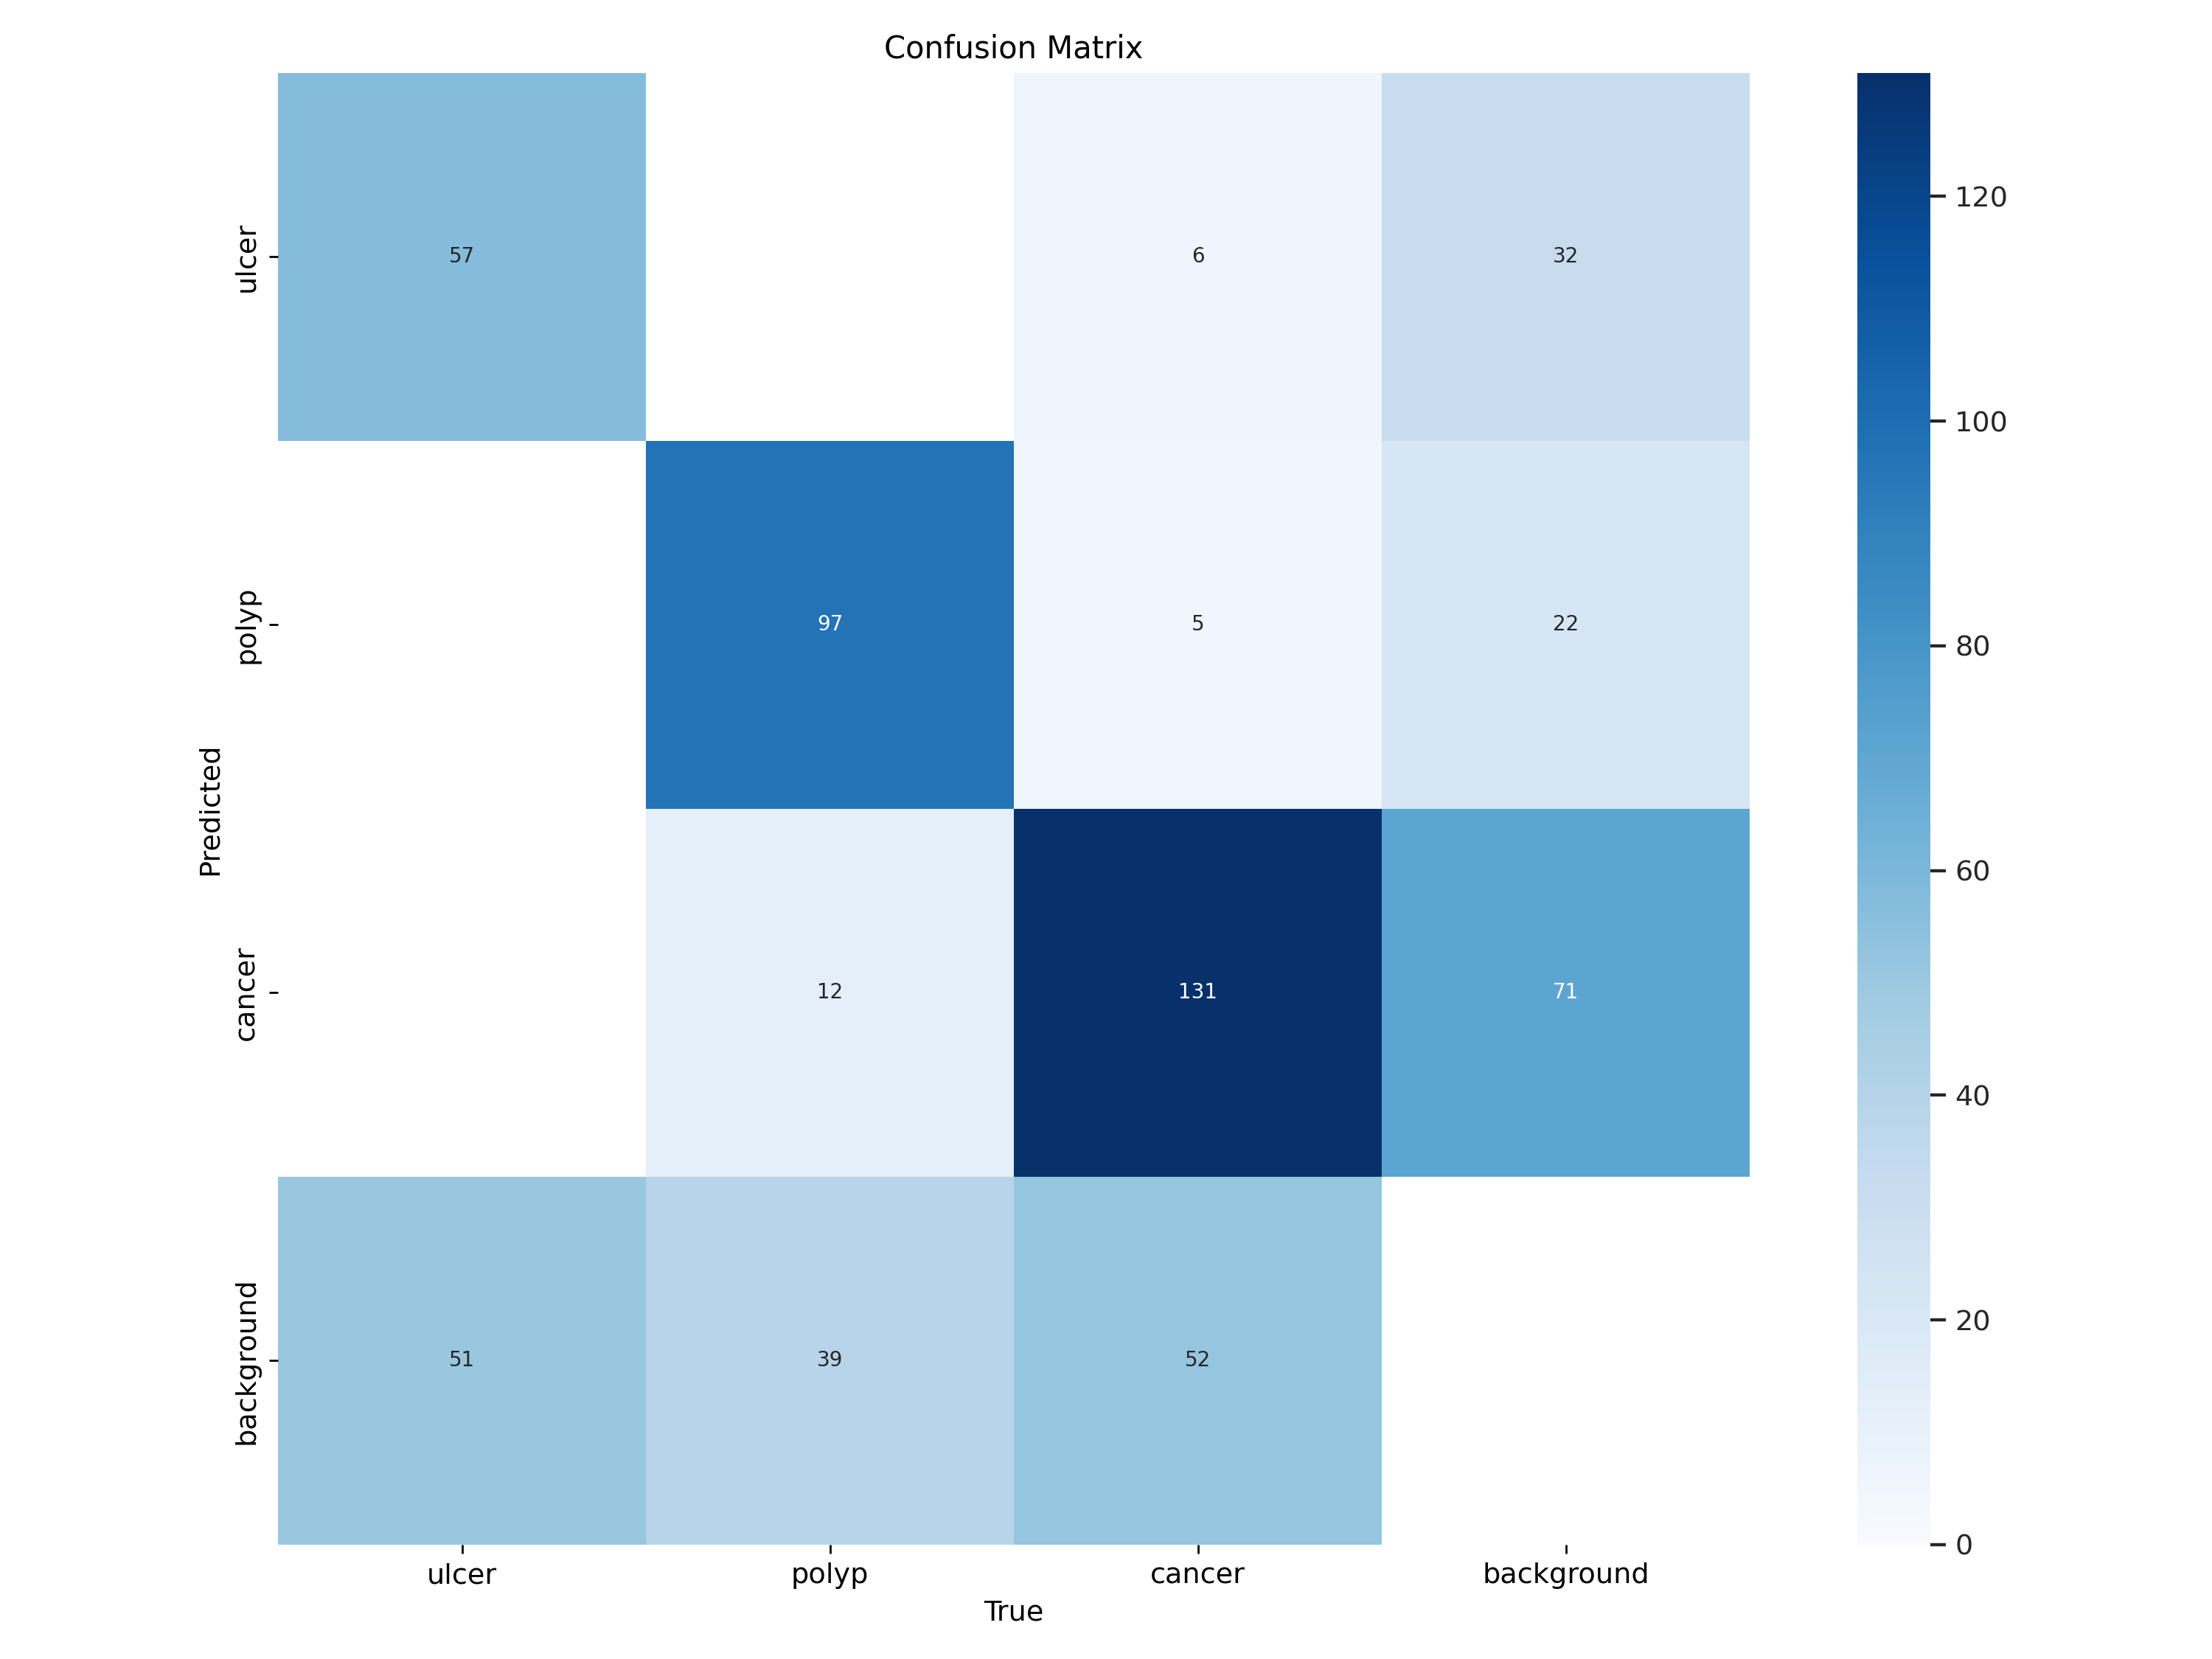

In [2]:
from PIL import Image
Image.open('/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/confusion_matrix.png')

In [3]:
Image.open('/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v3/exp33/train_batch0.jpg')